
<h1 style="text-align: center;">Trabajo Práctico Nº 4</h1>

In [33]:
import cv2
import matplotlib.pyplot as plt
import os 
import numpy as np

## Ejercicio 1

¿Qué hace la Transformada de Hough y cuáles son sus pasos?
La Transformada de Hough permite detectar líneas rectas en una imagen, transformando el problema de detectar alineaciones de píxeles en el espacio imagen a detectar acumulaciones en el espacio de parámetros 
(
𝜌
,
𝜃
)
(ρ,θ).
Los pasos vistos en clases son:

1. Hallar los bordes de la imagen utilizando un método de detección de bordes.
2. Umbralizar para obtener una imagen binaria.
3. Subdividir el plano 
(
𝜌
,
𝜃
)
(ρ,θ) discretizando en una cantidad específica de puntos.

4. Para cada píxel blanco de la imagen, decidir si cumple la ecuación normal de la recta. En caso afirmativo, aumentar el acumulador.
5. Examinar el contenido de las celdas del acumulador con altas concentraciones (máximo o umbral).
6. Graficar las rectas encontradas.

#### Detección de bordes previa con Canny
Para que la Transformada de Hough funcione correctamente, es fundamental contar con una imagen que contenga solo los bordes relevantes. Para ello, utilizamos el detector de bordes de Canny, tal como lo habíamos trabajado en el TP3.
Probamos distintos valores de umbrales y evaluamos los resultados visualmente.

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


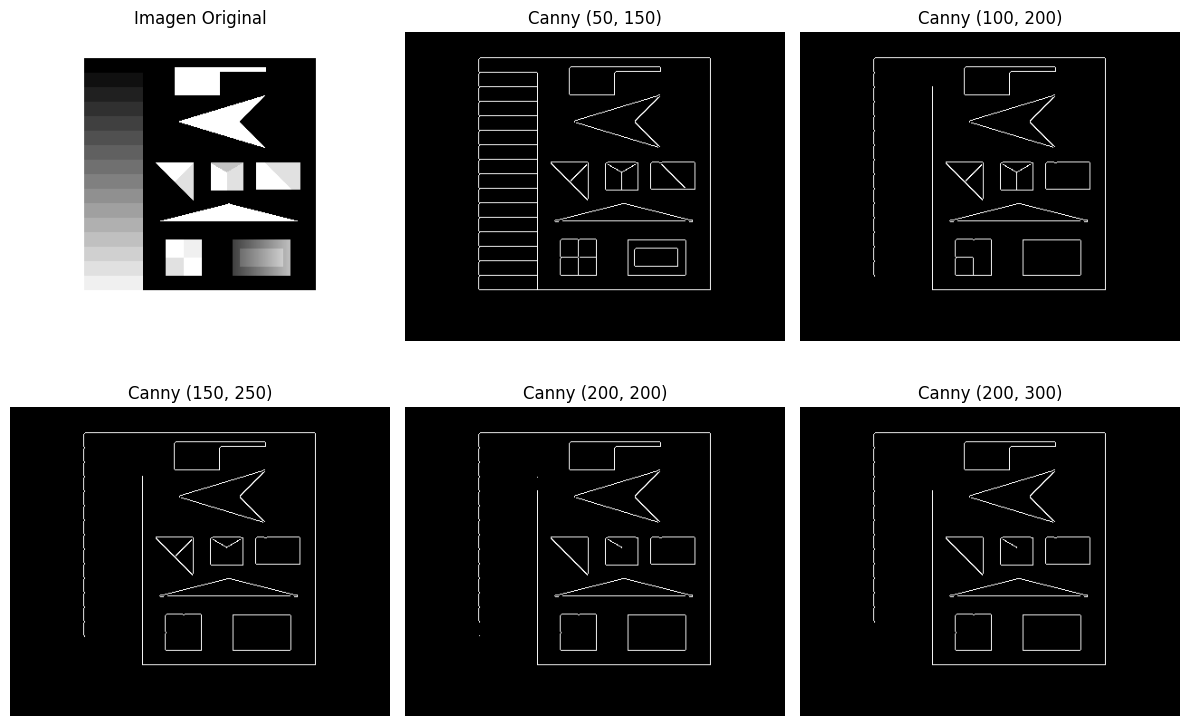

In [45]:
# Cargar imagen en escala de grises y como viene ya para tenerla cargada
imagen = cv2.imread('test.png', cv2.IMREAD_GRAYSCALE)
img = cv2.imread('test.png')  
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Verificamos que la imagen se haya cargado correctamente
if imagen is None:
    raise FileNotFoundError("No se encontró la imagen 'test.png'.")

# Umbrales de prueba para Canny
parametros_canny = [
    (50, 150),
    (100, 200),
    (150, 250),
    (200, 200),
    (200, 300),
]

# Crear figura para mostrar los resultados
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.title("Imagen Original")
plt.imshow(imagen, cmap='gray')
plt.axis('off')

# Aplicar y mostrar Canny con distintos umbrales
for i, (umbral_min, umbral_max) in enumerate(parametros_canny):
    bordes = cv2.Canny(imagen, umbral_min, umbral_max)
    plt.subplot(2, 3, i + 2)
    plt.title(f'Canny ({umbral_min}, {umbral_max})')
    plt.imshow(bordes, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


Tras comparar los resultados, observamos que el par de umbrales (50,150) fue el que permitió preservar más bordes, incluyendo detalles finos.
Con ese resultado aplicamos la Transformada de Hough clásica, que detecta líneas infinitas representadas por sus parámetros 
(
𝜌
,
𝜃
)
(ρ,θ). Las líneas detectadas se graficaron sobre la imagen original.

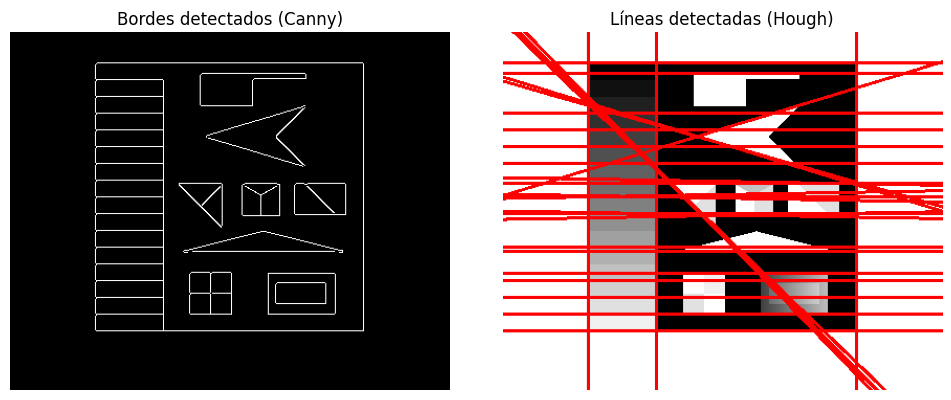

In [46]:
# 1. Detección de bordes con Canny
edges = cv2.Canny(gray, threshold1=50, threshold2=150, apertureSize=3)

# Mostrar bordes detectados
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title('Bordes detectados (Canny)')
plt.axis('off')

# 2. Aplicar Transformada de Hough
# rho = 1 pixel, theta = 1 grado (en radianes), threshold = mínimo de votos
lines = cv2.HoughLines(edges, rho=1, theta=np.pi / 180, threshold=70)

# 3. Dibujar líneas detectadas sobre la imagen original
img_lines = img.copy()

if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        # Calculamos dos puntos grandes para que la línea se extienda sobre la imagen
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(img_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)

# 4. Mostrar imagen con líneas detectadas
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_lines, cv2.COLOR_BGR2RGB))
plt.title('Líneas detectadas (Hough)')
plt.axis('off')

plt.tight_layout()
plt.show()


Al aplicar la Transformada de Hough clásica sobre la imagen procesada con el detector de bordes de Canny (umbral 50–150), observamos que el parámetro threshold de Hough cumple un rol clave en la sensibilidad del método.

Probamos distintos valores de threshold y comprobamos lo siguiente:

Con valores más altos, como 100 o más, se detectan únicamente las líneas más prominentes, ignorando bordes finos o líneas entrecortadas.

Con valores moderados o bajos (como 70 u 80), se logra un equilibrio entre sensibilidad y ruido, detectando muchas líneas importantes sin sobrecargar el resultado.

Sin embargo, al bajar mucho el threshold, aparecen líneas superpuestas, redundantes o inclinadas que no representan contornos reales de la imagen. Esto se puede observar en la figura, donde hay varias líneas casi idénticas acumuladas, o líneas diagonales que atraviesan toda la imagen sin corresponder a bordes reales.

Este comportamiento se debe a que la Hough clásica considera líneas infinitas, y pequeñas variaciones en los bordes (o ruido leve en el acumulador) pueden generar múltiples líneas cercanas entre sí.

En conclusión, ajustar el parámetro threshold es fundamental para balancear entre detección y precisión, evitando tanto la omisión de líneas importantes como la aparición de detecciones falsas o duplicadas.

Luego, aplicamos la versión probabilística cv2.HoughLinesP, que en lugar de representar líneas infinitas, devuelve segmentos de línea concretos definidos por sus puntos extremos 
(
𝑥
1
,
𝑦
1
)
(x 
1
​
 ,y 
1
​
 ) y 
(
𝑥
2
,
𝑦
2
)
(x 
2
​
 ,y 
2
​
 ).
Esta versión permite trabajar con líneas más cortas o interrumpidas, y tiene parámetros adicionales como:

minLineLength: longitud mínima para considerar una línea.

maxLineGap: separación máxima para unir dos puntos en una misma línea.

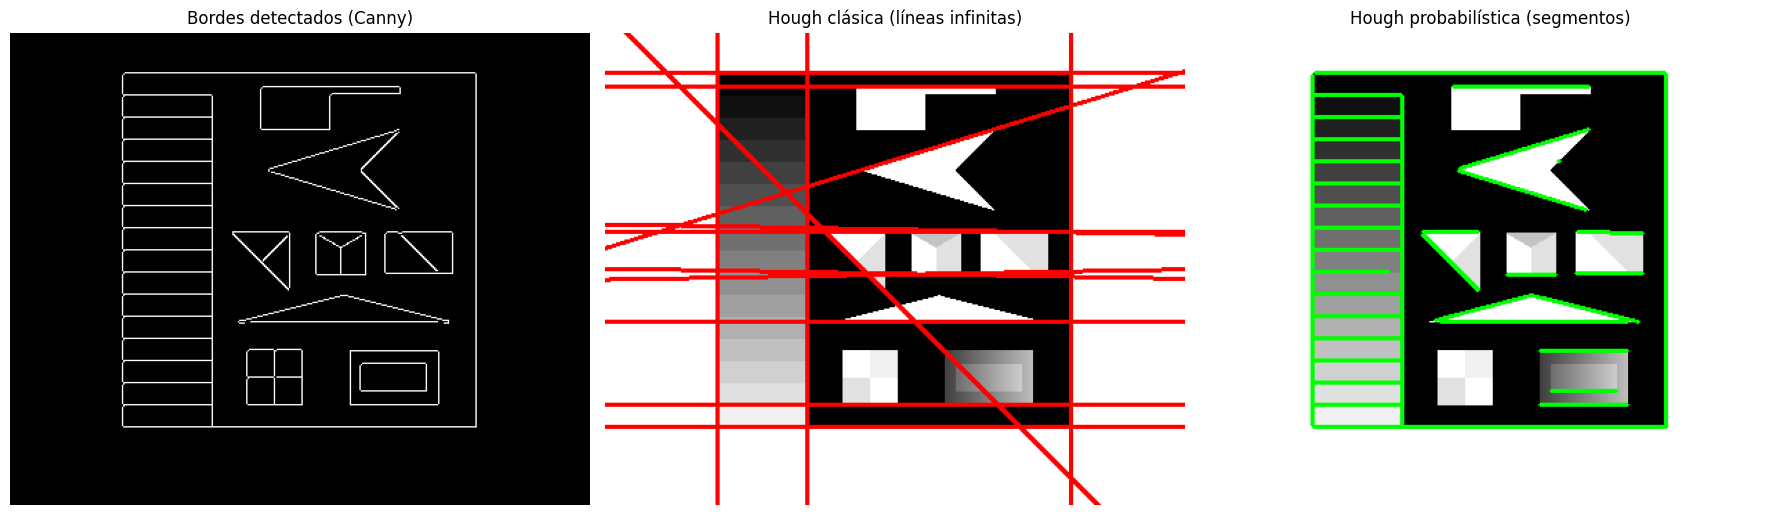

In [ ]:
# 1. Detección de bordes con Canny
edges = cv2.Canny(gray, threshold1=50, threshold2=150, apertureSize=3)

# 2A. Transformada de Hough clásica (líneas infinitas)
lines = cv2.HoughLines(edges, rho=1, theta=np.pi/180, threshold=80)
img_hough = img.copy()
if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(img_hough, (x1, y1), (x2, y2), (0, 0, 255), 2)  # rojo

# 2B. Transformada de Hough probabilística (segmentos finitos)
lines_p = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=50,
                          minLineLength=1, maxLineGap=5)
img_hough_p = img.copy()
if lines_p is not None:
    for line in lines_p:
        x1, y1, x2, y2 = line[0]
        cv2.line(img_hough_p, (x1, y1), (x2, y2), (0, 255, 0), 2)  # verde

# 3. Mostrar resultados
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Bordes detectados (Canny)')
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Hough clásica (líneas infinitas)')
plt.imshow(cv2.cvtColor(img_hough, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Hough probabilística (segmentos)')
plt.imshow(cv2.cvtColor(img_hough_p, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


Probamos diferentes combinaciones de parámetros (umbral, longitud mínima, separación máxima) para ambas versiones de Hough con el objetivo de detectar la mayor cantidad de líneas posibles.

Como conclusión, la versión probabilística resultó más detallada y realista, permitiendo representar segmentos individuales de los objetos.
Sin embargo, notamos un problema recurrente en ambos métodos: ninguno fue capaz de detectar (sin poner threshold que contaminaran demasiado la imagen) correctamente los cuadrados pequeños de la zona inferior izquierda de la imagen, ni la primera forma geometrica de margen superior. Tampoco se observa que hayan detectado el cuadrado del medio de la imagen
Este fallo puede deberse a que los lados de esos cuadrados son muy cortos, están demasiado juntos, o la detección de bordes previa no los separó bien, lo cual limita la acumulación de votos o la unión en segmentos.

## Ejercicio 2

### SIFT
###
El método SIFT (Scale-Invariant Feature Transform) se utiliza para para detectar y describir puntos clave en una imagen que son invariantes a transformaciones como escala, rotación e iluminación.  SIFT localiza características distintivas en una imagen mediante la identificación de puntos de interés (keypoints) y el cálculo de descriptores, que representan la estructura local alrededor de cada punto clave. Estos descriptores se pueden comparar entre imágenes para encontrar coincidencias, lo cual permite reconocer objetos o partes de una escena incluso bajo variaciones significativas.
##### Primero realizamos la transformación de la imagen original en diversas formas, y la guardamos en la misma ubicación que la original. Las modificaciones que se aplican sobre la imagen son:
 
1. **Rotación**: Aplica rotaciones de 15, 30, 45 y 60 grados.
2. **Traslación**: Aplica desplazamientos de 30 o 50 píxeles en distintas direcciones.
3. **Escala**: Cambia el tamaño de la imagen a escalas de 0.5, 0.75, 1.5 y 2.0.
4. **Iluminación**: Ajusta el brillo de la imagen multiplicando los valores de píxeles.
5. **Perspectiva**: Aplica dos transformaciones de perspectiva que deforman la imagen.
##### Además, se utilizará una imagen diferente a la elegida para probar si funciona correctamente el algoritmo implementado.

In [50]:
# Se carga la imagen original
imagen = cv2.imread('rada_tilly.jpeg')

# Función para guardar la imagen modificada
def guardar_imagen(imagen, nombre):
    cv2.imwrite(nombre, imagen)

# 1. Rotación de la imagen
for angulo in [15, 30, 45, 60]:
    altura, ancho = imagen.shape[:2]
    matriz_rotacion = cv2.getRotationMatrix2D((ancho // 2, altura // 2), angulo, 1)
    imagen_rotada = cv2.warpAffine(imagen, matriz_rotacion, (ancho, altura))
    guardar_imagen(imagen_rotada, f"Images_SIFT/rada_rotada_{angulo}.png")

# 2. Traslación de la imagen
for dx, dy in [(30, 50), (-30, -50), (50, -30), (-50, 30)]:
    matriz_traslacion = np.float32([[1, 0, dx], [0, 1, dy]])
    imagen_trasladada = cv2.warpAffine(imagen, matriz_traslacion, (ancho, altura))
    guardar_imagen(imagen_trasladada, f'Images_SIFT/rada_trasladada_{dx}_{dy}.png')

# 3. Cambio de escala
for escala in [0.5, 0.75, 1.5, 2.0]:
    imagen_escalada = cv2.resize(imagen, None, fx=escala, fy=escala, interpolation=cv2.INTER_LINEAR)
    guardar_imagen(imagen_escalada, f'Images_SIFT/rada_escalada_{escala}.png')

# 4. Cambio de iluminación
for alpha in [0.5, 1.5, 2.0]:  # Factor de brillo
    imagen_iluminada = cv2.convertScaleAbs(imagen, alpha=alpha, beta=0)
    guardar_imagen(imagen_iluminada, f'Images_SIFT/rada_iluminada_{alpha}.png')

# 5. Transformación de perspectiva
puntos_originales = np.float32([[0, 0], [ancho - 1, 0], [0, altura - 1], [ancho - 1, altura - 1]])
puntos_destino = [
    np.float32([[0, 0], [ancho - 1, 0], [ancho * 0.1, altura - 1], [ancho * 0.9, altura - 1]]),
    np.float32([[ancho * 0.1, 0], [ancho * 0.9, 0], [0, altura - 1], [ancho - 1, altura - 1]]),
]
for i, destino in enumerate(puntos_destino):
    matriz_perspectiva = cv2.getPerspectiveTransform(puntos_originales, destino)
    imagen_perspectiva = cv2.warpPerspective(imagen, matriz_perspectiva, (ancho, altura))
    guardar_imagen(imagen_perspectiva, f'Images_SIFT/rada_perspectiva_{i}.png')

print("Imágenes modificadas generadas y guardadas.")

Imágenes modificadas generadas y guardadas.


## Ejercicio 3

**a) En el método Transformada de Hough, al final del algoritmo, ¿qué significa que una celda \( A_{ij} \) tenga el número 20?**

Significa que la celda ubicada en la posición \( (i, j) \) del acumulador de Hough recibió **20 votos**.  
Esto quiere decir que **20 píxeles del borde de la imagen original** están alineados según los parámetros \( \rho_i \) y \( \theta_j \), es decir, que **20 puntos distintos consideran que existe una línea** con esa inclinación y distancia al origen.

Cuanto mayor sea ese valor, más evidencia hay de que esa combinación de parámetros representa una **línea real** en la imagen.


**b) ¿Qué es el espacio escala Gaussiano?**

Es una representación de una imagen en múltiples niveles de escala, obtenidos aplicando filtros Gaussianos con diferentes valores de sigma (σ).  
Se construye suavizando progresivamente la imagen para detectar estructuras a diferentes escalas, lo cual es esencial en algoritmos como SIFT para asegurar invariancia a la escala.

Cada nivel de esta representación se obtiene mediante la convolución de la imagen con un filtro Gaussiano, lo que se expresa como:

$$
L(x, y, \sigma) = G(x, y, \sigma) * I(x, y)
$$

donde:

- \( L(x, y, \sigma) \) es la imagen suavizada en una cierta escala σ,  
- \( G(x, y, \sigma) \) es el filtro Gaussiano con desviación estándar σ,  
- \( I(x, y) \) es la imagen original,  
- * representa la operación de convolución.


**c) ¿Qué es un extremo 3D en el método SIFT?**

En el algoritmo SIFT, un extremo 3D es un punto clave (keypoint) candidato que se detecta como un **máximo o mínimo local** dentro de un entorno tridimensional definido por:

- las coordenadas espaciales (x, y),  
- y la escala (σ), a lo largo del espacio de escalas Gaussiano.

Este análisis se realiza sobre las imágenes generadas por la **Diferencia de Gauss (DoG)**.  
Cada punto es comparado con sus **26 vecinos**: 8 en la misma imagen, 9 en la imagen anterior en escala, y 9 en la siguiente. Si el punto es mayor o menor que todos ellos, se considera un **extremo 3D**, y puede convertirse en un keypoint estable.

Este proceso permite detectar puntos invariantes no solo a rotación y traslación, sino también a escala.


<hr>
<p style="text-align: center;">
Nombre: <strong>Sosa Suarez Santiago</strong><br>
Materia: <em>Análisis y Tratamiento de Imágenes Satelitales</em><br>
Maestría en Ciencia de Datos – <em>ITBA</em><br>
Fecha: 09 de Julio de 2025
</p>
<hr>